Laboratorio 3
integrantes:

- Francis Aguilar - 22243
- César López - 22535
- Angela García -22869
 
enlace al repositorio: https://www.kaggle.com/code/angelargd8/lab3-ds

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image

2025-08-01 06:14:19.570482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754028859.825603      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754028859.904128      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Análisis exploratorio

In [3]:
print("Contenido de /kaggle/input:")
print(os.listdir("/kaggle/input"))

Contenido de /kaggle/input:
['mnist-multiple-dataset-comprehensive-analysis']


In [4]:
base_root = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"

print("Contenido dentro del dataset:")
print(os.listdir(base_root))

Contenido dentro del dataset:
['label.json', 'model.pth', 'README.md', 'PolyMNIST', 'label.csv', 'MNIST-MIX-all']


In [5]:
poly_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST"
print("Contenido en PolyMNIST:", os.listdir(poly_path))

Contenido en PolyMNIST: ['MMNIST']


In [6]:
mmnist_path = os.path.join(poly_path, "MMNIST")
print("Contenido en MMNIST:", os.listdir(mmnist_path))

Contenido en MMNIST: ['test', 'train']


In [7]:
train_path = os.path.join(mmnist_path, "train")
print("Contenido en train:", os.listdir(train_path))

Contenido en train: ['m4', 'm2', 'm0', 'm1', 'm3']


El conjunto de datos de polyMNIST tiene cinco modalidades distintas. El fondo de cada modalidad se compone de parches aleatorios recortados de una imagen más grande, con el dígito colocado aleatoriamente dentro de estos parches. Esta configuración proporciona a cada modalidad información única de su imagen de fondo, mientras que el dígito sirve como información compartida entre todas las modalidades. Un desafío adicional, en comparación con el PolyMNIST original, es la traducción aleatoria de los dígitos.

Descripción tomada de: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data

En el conjunto de datos, algo importante de ver antes de colocar los datos en un dataframe, es que el nombre de los archivos tiene el siguiente formato:

**id.etiqueta.png**


In [8]:
#leer las imagenes del dataset y extraer sus etiquetas 
base_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train"

data = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".png"):
            full_path = os.path.join(root, file)
            label = file.split('.')[1]
            data.append((full_path, int(label)))

df = pd.DataFrame(data, columns=["filepath", "label"])
print(df.head(), "\nTotal imágenes:", len(df))


                                            filepath  label
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9 
Total imágenes: 300000


In [9]:
print("Primeras filas del DataFrame:")
print(df.head())


Primeras filas del DataFrame:
                                            filepath  label
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9


In [10]:
# Ver tamaño del dataset
print("\nNúmero total de imágenes:", len(df))



Número total de imágenes: 300000


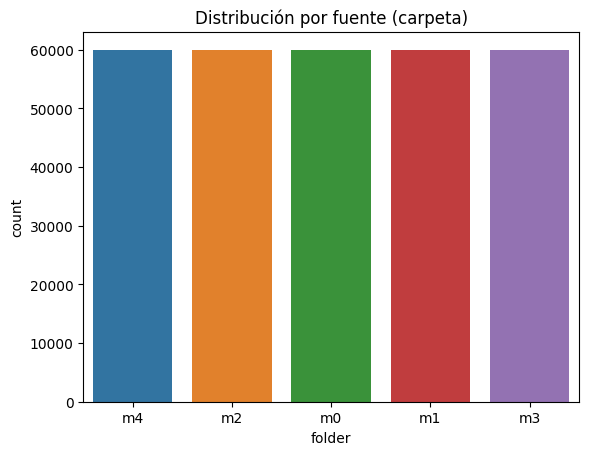

In [11]:
#imagenes por cada carpeta
df['folder'] = df['filepath'].apply(lambda x: x.split('/')[-2])
sns.countplot(data=df, x="folder")
plt.title("Distribución por fuente (carpeta)")
plt.show()

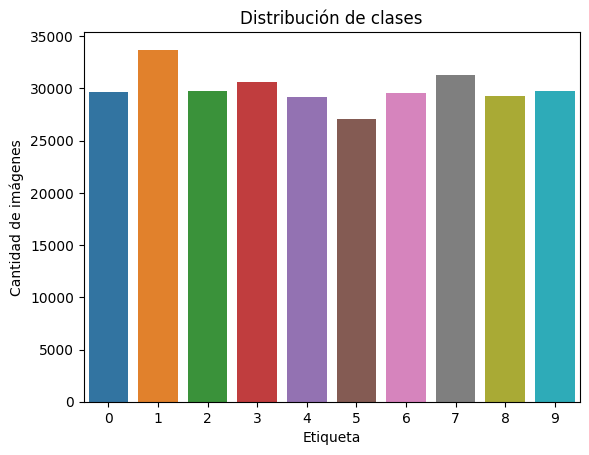

In [12]:
sns.countplot(data=df, x="label")
plt.title("Distribución de clases")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad de imágenes")
plt.show()

La distribución de clases no parece tener un gran desbalance, sin embargo es ideal que este balanceada. En este caso se usara unsersampling, ya que son muchos datos y no tienen una gran diferencia en cuanto datos.

In [13]:
#balancear las clases, esta vez undersampling porque muy grande el dataset
from sklearn.utils import resample

min_count = df['label'].value_counts().min()
df = pd.concat([
    resample(df[df['label'] == label], replace=False, n_samples=min_count, random_state=42)
    for label in df['label'].unique()
])

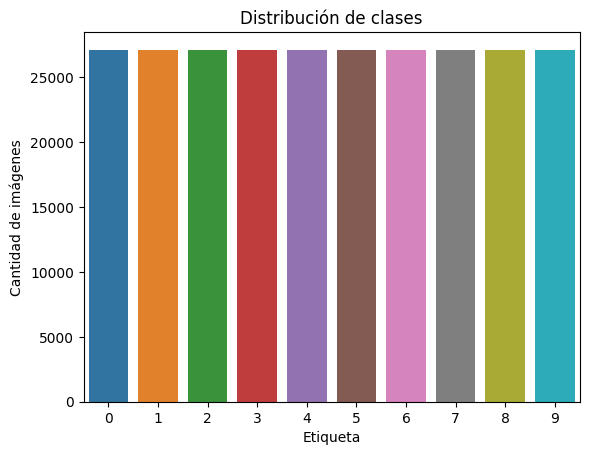

In [14]:
sns.countplot(data=df, x="label")
plt.title("Distribución de clases")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [15]:
# Duplicados por nombre
print("Duplicados:", df.duplicated("filepath").sum())

Duplicados: 0


In [16]:
# Tamaños de imagen
df['size'] = df['filepath'].apply(lambda path: Image.open(path).size)
print("Tamaños únicos:", df['size'].value_counts())

Tamaños únicos: size
(28, 28)    271050
Name: count, dtype: int64


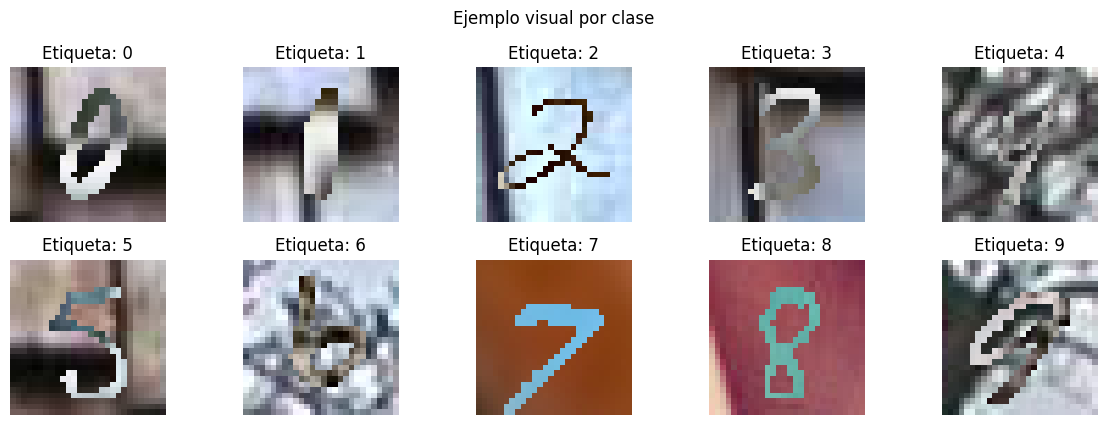

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

# Asegura que la columna 'label' es int
df['label'] = df['label'].astype(int)

# Obtener clases únicas
unique_labels = sorted(df['label'].unique())

# Mostrar una imagen por clase (máximo 10 si quieres limitar)
plt.figure(figsize=(12, 4))

for i, label in enumerate(unique_labels[:10]):
    subset = df[df['label'] == label]
    if not subset.empty:
        img_path = subset.iloc[0]['filepath']
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Etiqueta: {label}")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Ejemplo visual por clase", y=1.05)
plt.show()

En los ejemplos, se logra observar que dataset tiene una alta variabilidad visual y estilo porque cada uno tiene colores, fondos, tipografía, estilo de escritura y ruido. Y hay ciertos números que puede que por su fondo que tienen mucho ruido pueda causar problemas con el entrenamiento.

#### Preparacion de datos

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Ruta base
base_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST"

# Altura, ancho e input shape (ajustar si cambia)
img_height, img_width = 28, 28
input_shape = (img_height, img_width, 1)  # grayscale
batch_size = 64


In [19]:
import os
import cv2
import numpy as np
from tqdm import tqdm

img_height, img_width = 28, 28
base_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST"
modalidades = ['m0', 'm1', 'm2', 'm3', 'm4']

def cargar_datos(modalidades, tipo='train'):
    X = []
    y = []

    for mod in modalidades:
        path = os.path.join(base_path, tipo, mod)
        archivos = sorted(os.listdir(path))

        for nombre in tqdm(archivos, desc=f'Cargando {tipo}/{mod}'):
            if nombre.endswith('.png'):
                etiqueta = int(float(nombre.split('.')[1]))
                img_path = os.path.join(path, nombre)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_width, img_height))  # Asegura tamaño uniforme
                img = img.astype('float32') / 255.0  # Normalizar

                X.append(img)
                y.append(etiqueta)

    X = np.expand_dims(np.array(X), -1)
    y = np.array(y)
    return X, y

# Cargar datos de entrenamiento y prueba desde modalidad m0
X_train, y_train = cargar_datos(modalidades=['m0', 'm1', 'm2', 'm3', 'm4'], tipo='train')
X_test, y_test = cargar_datos(modalidades=['m0', 'm1', 'm2', 'm3', 'm4'], tipo='test')
print("Clases:", np.unique(y_train))


Cargando test/m4: 100%|██████████| 10000/10000 [01:34<00:00, 105.92it/s]


Clases: [0 1 2 3 4 5 6 7 8 9]


In [20]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (300000, 28, 28, 1) (300000,)
Test: (50000, 28, 28, 1) (50000,)


In [21]:
# Configuración básica
altura, ancho, canales = img_height, img_width, 1
num_clases = len(np.unique(y_train))

#### Funcion para evaluar modelos

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import numpy as np

def evaluar_modelo(modelo, X_test, y_test, nombre="Modelo"):
    print(f"\n=== Evaluación de {nombre} ===")
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {acc:.4f} - Loss: {loss:.4f}\n")

    y_pred = modelo.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(classification_report(y_test, y_pred_classes, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    plt.show()


#### Modelo CNN - 1

In [23]:
model1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-01 07:01:50.491409: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 163s 17ms/step - accuracy: 0.8513 - loss: 0.4845 - val_accuracy: 0.9466 - val_loss: 0.1698
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 161s 17ms/step - accuracy: 0.9583 - loss: 0.1316 - val_accuracy: 0.9628 - val_loss: 0.1173
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 158s 17ms/step - accuracy: 0.9698 - loss: 0.0926 - val_accuracy: 0.9611 - val_loss: 0.1270
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 161s 17ms/step - accuracy: 0.9750 - loss: 0.0752 - val_accuracy: 0.9670 - val_loss: 0.1141
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 161s 17ms/step - accuracy: 0.9791 - loss: 0.0631 - val_accuracy: 0.9668 - val_loss: 0.1132
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 160s 17ms/step - accuracy: 0.9810 - loss: 0.0561 - val_accuracy: 0.9683 - val_loss: 0.1226
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 161s 17ms/step - accuracy: 0.9834 - loss: 0.0491 - val_accuracy: 0.9639 - val_loss: 0.1429
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 


=== Evaluación de CNN 1 ===
Accuracy: 0.9681 - Loss: 0.1461

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4900
           1       0.99      0.98      0.98      5675
           2       0.98      0.97      0.97      5160
           3       0.96      0.97      0.96      5050
           4       0.98      0.96      0.97      4910
           5       0.96      0.97      0.96      4460
           6       0.98      0.97      0.98      4790
           7       0.97      0.97      0.97      5140
           8       0.96      0.95      0.96      4870
           9       0.94      0.96      0.95      5045

    accuracy                           0.97     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.97      0.97      0.97     50000



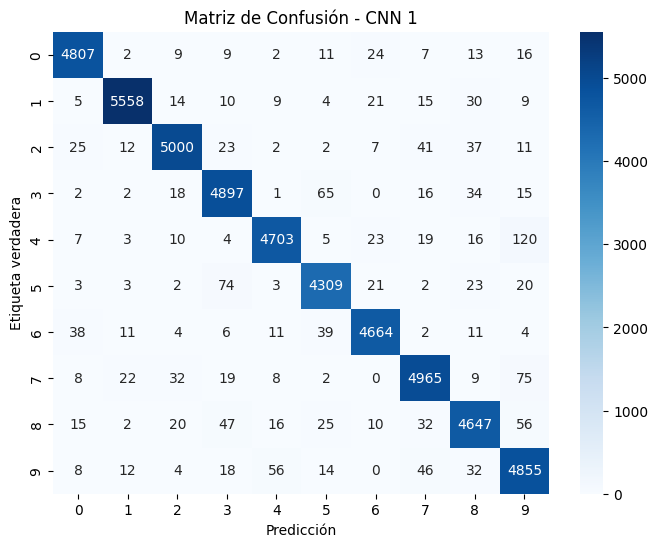

In [24]:
evaluar_modelo(model1, X_test, y_test, "CNN 1")

#### Modelo CNN - 2

In [25]:
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_clases, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 260s 27ms/step - accuracy: 0.8561 - loss: 0.4530 - val_accuracy: 0.8947 - val_loss: 0.3109
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 256s 27ms/step - accuracy: 0.9499 - loss: 0.1673 - val_accuracy: 0.9545 - val_loss: 0.1460
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 258s 27ms/step - accuracy: 0.9575 - loss: 0.1402 - val_accuracy: 0.9688 - val_loss: 0.1060
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 257s 27ms/step - accuracy: 0.9635 - loss: 0.1214 - val_accuracy: 0.9476 - val_loss: 0.1717
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 257s 27ms/step - accuracy: 0.9658 - loss: 0.1120 - val_accuracy: 0.9655 - val_loss: 0.1155
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 256s 27ms/step - accuracy: 0.9681 - loss: 0.1050 - val_accuracy: 0.9486 - val_loss: 0.1635
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 258s 27ms/step - accuracy: 0.9704 - loss: 0.0964 - val_accuracy: 0.9701 - val_loss: 0.0993
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - accuracy: 


=== Evaluación de CNN 2 ===
Accuracy: 0.9749 - Loss: 0.0876

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4900
           1       0.98      0.99      0.98      5675
           2       0.99      0.97      0.98      5160
           3       0.97      0.98      0.98      5050
           4       0.97      0.98      0.97      4910
           5       0.97      0.97      0.97      4460
           6       0.98      0.98      0.98      4790
           7       0.96      0.98      0.97      5140
           8       0.98      0.96      0.97      4870
           9       0.97      0.96      0.96      5045

    accuracy                           0.97     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.98      0.97      0.97     50000



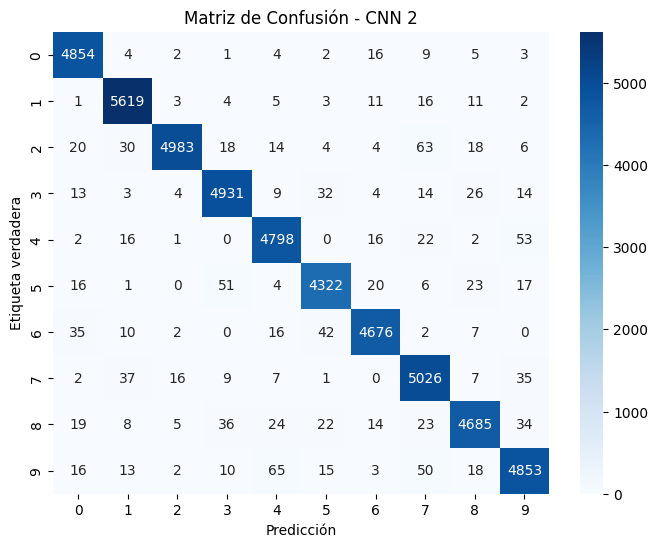

In [26]:
evaluar_modelo(model2, X_test, y_test, "CNN 2")

#### Conclusion:
Luego de entrenar y comparar ambos modelos, notamos que los dos tienen un rendimiento bastante bueno al reconocer los dígitos. Sin embargo, el segundo modelo (CNN 2) fue un poco más preciso, especialmente en la validación con datos que no había visto antes. También tuvo un error menor y menos confusión entre los números parecidos. Por eso, decidimos quedarnos con el modelo CNN 2, ya que es más robusto y generaliza mejor en nuevas imágenes.



#### Modelo Red Neuronal Simple

In [27]:
model_simple = models.Sequential([
    layers.Flatten(input_shape=(altura, ancho, canales)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

model_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_simple.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.4734 - loss: 1.5333 - val_accuracy: 0.7145 - val_loss: 0.9182
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7179 - loss: 0.8961 - val_accuracy: 0.7462 - val_loss: 0.8210
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7545 - loss: 0.7901 - val_accuracy: 0.7510 - val_loss: 0.7839
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7709 - loss: 0.7338 - val_accuracy: 0.7924 - val_loss: 0.6953
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7833 - loss: 0.6988 - val_accuracy: 0.7706 - val_loss: 0.7363
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.7923 - loss: 0.6694 - val_accuracy: 0.7859 - val_loss: 0.7054
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.8002 - loss: 0.6461 - val_accuracy: 0.7881 - val_loss: 0.6893
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.8073 - loss: 0